
# Project: Investigate a Dataset (No-show appointments)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

Investigate the No-show appointments dataset. 
    Does men or women tend to No-show?
    Would Age difference and no. of days after schedule cause No-show?


In [64]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [65]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
df = pd.read_csv(r'C:\Users\kin31\Documents\noshowappointments-kagglev2-may-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [66]:
#check if any duplicated data
df.duplicated().sum()

0

In [67]:
#check if any null
df.isnull().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64


### Data Cleaning (Replace this with more specific notes!)

In [68]:
# After discussing the structure of the data and any problems that need to be
#   cleaned, perform those cleaning steps in the second part of this section.

In [69]:
# Drop NA
df.dropna(inplace=True)

In [70]:
# Check if there is any NA
df.isnull().sum().any()

False

In [71]:
# Drop PatientId, AppointmentID
df.drop(['PatientId','AppointmentID','Neighbourhood'],axis=1, inplace=True)

In [72]:
# Rename No-show as No_show
df.rename(columns={"No-show":"No_show", "ScheduledDay":"Scheduled_Day", "AppointmentDay":"Appointment_Day"}, inplace=True)

In [73]:
#  Change AppointmentDay adn ScheduledDay to datetime format
df['Scheduled_Day'] = pd.to_datetime(df['Scheduled_Day']).dt.date
df['Appointment_Day'] = pd.to_datetime(df['Appointment_Day']).dt.date

In [74]:
df.shape

(110527, 11)

In [75]:
# Drop the row with Age = -1
df.drop(df[df['Age'] < 0].index, inplace=True)

In [76]:
# Drop rows with Appointment_Day eariler than Scheduled_Day
df.drop(df[df['Appointment_Day'] < df['Scheduled_Day']].index, inplace=True)

<a id='eda'></a>
## Exploratory Data Analysis


### Research Question 1 (Does man or woman tend to No-show?)

In [77]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.

In [78]:
total_men = df.query('Gender == "M"')['Gender'].count()
total_women = df.query('Gender == "F"')['Gender'].count()
total_men, total_women

(38685, 71836)

In [79]:
# find the no. of no-show men and women
No_show_gender = df.groupby(['No_show','Gender']).size().reset_index()
No_show_gender.columns = [*No_show_gender.columns[:-1], 'Count']
No_show_women = No_show_gender[(No_show_gender.No_show == "Yes") & (No_show_gender.Gender == "F")]['Count'].values[0]
No_show_men = No_show_gender[(No_show_gender.No_show == "Yes") & (No_show_gender.Gender == "M")]['Count'].values[0]
No_show_men, No_show_women

(7723, 14591)

In [80]:
# find the Proportion of no-show men and women
prop_men = No_show_men /total_men
prop_women = No_show_women /total_women
prop_men, prop_women 

(0.19963810262375598, 0.2031154295896208)

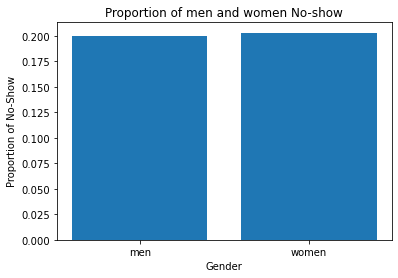

In [132]:
## Reasoning: No. of no-show women is twice amount of men. Women should be more likely to no-show.
plt.bar(["men", "women"], [prop_men, prop_women])
plt.title("Proportion of men and women No-show")
plt.xlabel("Gender")
plt.ylabel("Proportion of No-Show");

In [133]:
## Finding: the proprtions of men and women are similar, gender is not a factor of no-show.

### Research Question 2  (Investigate whether Age and no. of days after schedules are the factors of No-show)

In [82]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.

In [83]:
df_Noshow = df.query('No_show == "Yes"')

In [84]:
df_Noshow['No_of_days_after_schedule'] = (df_Noshow.iloc[:,2]- df_Noshow.iloc[:,1]).dt.days


<ipython-input-84-5272a08fc423>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Noshow['No_of_days_after_schedule'] = (df_Noshow.iloc[:,2]- df_Noshow.iloc[:,1]).dt.days


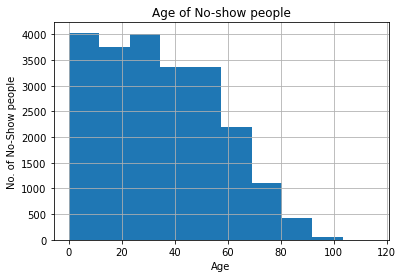

In [131]:
## Reasoning: Youngers are more busy than elderly, so the youngers tend to no-show. 
df_Noshow.Age.hist();
plt.title("Age of No-show people")
plt.xlabel("Age")
plt.ylabel("No. of No-Show people");

In [134]:
## Finding: The graph is left skewed. Younger paitents tend to no-show.

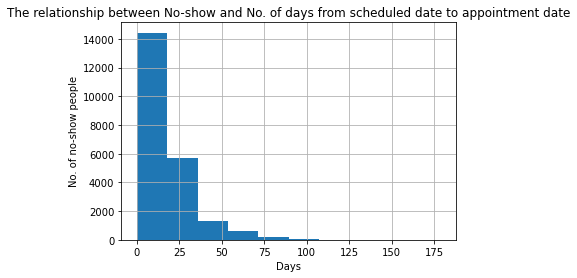

In [128]:
## Reasoning: Patients might forget their appointment if their appointment was to far from the scheduled date.

df_Noshow.No_of_days_after_schedule.hist();
plt.title("The relationship between No-show and No. of days from scheduled date to appointment date")
plt.xlabel("Days")
plt.ylabel("No. of no-show people");

In [130]:
## Finding: The graph is left skewed which means if the appointment date is very close to the scehduled date, patients tends to no-show.
##          the graph doesnt support the inference

<a id='conclusions'></a>
## Conclusions

From Question 1, although the no. no-show women is almost twice the amount of no-show men, the proportion of no-show men and women are very similar, the graph show no relation the gender.

From Question 2, Age of No-show people is more skewed to the left. it showed younger paitents tend to no-show.
the 2nd grap is skewed to the left. it meaned if the appointment date is very close to the scehduled date, patients tends to no-show.

Limitation:
The Appointment time is not provided to investigate whether it is one of the factor lead to No-show.
The cloumn 'Handcap' has value 1,2,3,4. the meaning is not understandable.
3539 patients with Age = 0, couldnt tell these were errors or they were babies less than 1 years old.

In [120]:
df['Handcap'].value_counts()


0    108282
1      2040
2       183
3        13
4         3
Name: Handcap, dtype: int64

In [127]:
df[df['Age'] == 0]

,Gender,Scheduled_Day,Appointment_Day,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show
59,F,2016-04-29,2016-04-29,0,0,0,0,0,0,0,No
63,M,2016-04-27,2016-04-29,0,0,0,0,0,0,0,No
64,M,2016-04-25,2016-04-29,0,0,0,0,0,0,1,No
65,M,2016-04-27,2016-04-29,0,0,0,0,0,0,0,No
67,F,2016-04-29,2016-04-29,0,0,0,0,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...
110345,F,2016-05-16,2016-06-01,0,0,0,0,0,0,0,No
110346,M,2016-06-06,2016-06-08,0,0,0,0,0,0,0,No
110454,F,2016-06-03,2016-06-03,0,0,0,0,0,0,0,No
110460,F,2016-06-03,2016-06-03,0,0,0,0,0,0,0,No
